In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
import lightgbm as lgb
import polyline
import tqdm

In [2]:
print('pandas: version {}'.format(pd.__version__))
print('sklearn: version {}'.format(sklearn.__version__))
print('numpy: version {}'.format(np.__version__))
print('tqdm: version {}'.format(tqdm.__version__))
print('lgb: version {}'.format(lgb.__version__))
print('polyline: version {}'.format(polyline.__version__))

pandas: version 0.25.3
sklearn: version 0.21.2
numpy: version 1.16.2
tqdm: version 4.38.0
lgb: version 2.3.0
polyline: version 1.4.0


## Загрузка данных

In [3]:
# Загружаем датасеты
train = pd.read_csv('train.csv')
valid = pd.read_csv('validation.csv')
test = pd.read_csv('test_additional.csv')
# Соединяем трейновый и валидационный датасет в один
train = pd.concat([train, valid], sort = False).reset_index(drop = True)

In [4]:
# Соединяем трейновый и тестовый сет в один
data = pd.concat([train, test], sort = False, axis = 0).reset_index(drop = True)
target = 'RTA'

## Генерация признаков

In [5]:
# MAPE
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Функция для подсчета дистанции между 2 точками
def dist(x_0, x_1):
    return ((x_0[0] - x_1[0]) ** 2 + (x_0[1] - x_1[1]) ** 2) ** (1/2)

In [6]:
# Переводим время в нужный формат
data['OrderedDate'] = pd.to_datetime(data['OrderedDate'])
# Добавляем час и день недели
data['hour'] = data['OrderedDate'].dt.hour
data['weekday'] = data['OrderedDate'].dt.weekday
# Считаем предпологаемую скорость
data['e_speed'] = data['ETA'] / data['EDA']
# Считаем дистанцию между началом и концом маршрута
data['dist'] = dist([data['latitude'].values, data['longitude'].values], 
            [data['del_latitude'].values, data['del_longitude'].values])
# Считаем дистанцию между началом маршрута и центром города
data['dist_center_start'] = dist([data['latitude'].values, data['longitude'].values], 
            [data['center_latitude'].values, data['center_longitude'].values])
# Смотрим отношения расстояния между началом и концом маршрута к предпологаемому расстоянию
data['div_dist'] = data['dist'] / data['EDA']

In [7]:
# Из датасета берем только 2,5 недели для обучения (так как эти данные наиболее релевантны)
max_train_date = data[~data[target].isnull()].OrderedDate.max().round('d')
start_date = max_train_date - pd.DateOffset(days=17)
data = data[data.OrderedDate >= start_date].reset_index(drop = True)
ltr = data[~data['RTA'].isnull()].shape[0]

In [8]:
# Делим наш трейн на фолды для подсчет средней скорости по каждому часу и  городу
def standart_split(data, target,  n_splits):
    split_list = []
    for i in range(n_splits):
        kf = KFold(n_splits=5, shuffle = True, random_state = 228 + i)
        for train_index, test_index in kf.split(data.iloc[:ltr, :], data[target][:ltr]):
            split_list += [(train_index, test_index)]
    return split_list
split_list = standart_split(data, target, 1)

In [9]:
alpha = 20
data['hour_locality'] = data['hour'].astype(str) + '_' + data['main_id_locality'].astype(str)
# Считаем реальную среднюю скорость
data['speed'] = data['RTA'] / data['RDA']
data['mean_speed_encoding'] = -1
# Для каждого фолда считаем сглаженную среднюю скорость по формуле (alpha * global_mean + mean * cnt) / (alpha + cnt)
# где mean - средняя скорость для данного города в данное время, cnt - кол-во поездок в данном городе в данное время в трейне,
# global_mean - средняя скорость по всему трейну и alpha - 20 (константа)
# Считаем для трейновой части по фолдам, чтобы предотвратить переобучение
for train_index, test_index in split_list:
    global_mean = data.loc[train_index, 'speed'].mean()
    mean_dict = data.loc[train_index, :].groupby('hour_locality')['speed'].mean().to_dict()
    cnt_dict =  data.loc[train_index, :].groupby('hour_locality').size().to_dict()
    mean_target = data.loc[test_index, 'hour_locality'].apply(
        lambda x: (alpha * global_mean + mean_dict.get(x, 0) * cnt_dict.get(x, 0)) / (alpha + cnt_dict.get(x, 0))).values
    data.loc[test_index, 'mean_speed_encoding'] = mean_target
# Считаем для тестовой части
global_mean = data.loc[:ltr-1, 'speed'].mean()
mean_dict = data.loc[:ltr-1, :].groupby('hour_locality')['speed'].mean().to_dict()
cnt_dict =  data.loc[:ltr-1, :].groupby('hour_locality').size().to_dict()
mean_target = data.loc[ltr:, 'hour_locality'].apply(
    lambda x: (alpha * global_mean + mean_dict.get(x, 0) * cnt_dict.get(x, 0)) / (alpha + cnt_dict.get(x, 0))).values
data.loc[ltr:, 'mean_speed_encoding'] = mean_target

In [158]:
import pickle
with open('additional_data.pickle', 'wb') as f:
    pickle.dump([global_mean, mean_dict, cnt_dict], f)

In [11]:
# Для предпологаемых путей посчитаем количество точек в маршруте
from tqdm.notebook import tqdm

route_list = []
for route in tqdm(data['route'].values):
    if route == route:
        route_list += [polyline.decode(route)]
    else:
        route_list += [()]
data['len_route'] = [len(x) for x in route_list]
# И посчитаем максимульную для между точками в каждом маршруте
dist_route_list = []
for route in tqdm(route_list):
    dist_route_list += [[dist(x_0, x_1) for x_0, x_1 in zip(route[:-1], route[1:])]]
data['max_route_part'] = [max(x) if len(x) > 0 else -1 for x in dist_route_list]

## Обучение модели

In [12]:
# Колонки для обучения
train_cols = ['ETA', 'latitude', 'del_latitude', 'longitude', 'del_longitude', 'hour', 'weekday', 'e_speed', 'dist',
              'dist_center_start', 'div_dist', 'mean_speed_encoding', 'len_route', 'max_route_part']
# Параметры lightgbm
param_lgb = { 'learning_rate':0.1,'num_leaves':6, 'objective':'mae',
                     'metric':'mape', 'feature_fraction': 0.8}

In [13]:
# Для валидации берем последнюю неделю
# Конец обучения
end_train = max_train_date - pd.DateOffset(days=7)
# Старт валидации
start_valid = max_train_date - pd.DateOffset(days=7)
# Окончание валидации
end_valid = max_train_date 
# Индексы для обучения и валидации
train_index = data[(data.OrderedDate < end_train)].index
val_index = data[(data.OrderedDate >=  start_valid) & (data.OrderedDate < end_valid)].index
# Предсказывать будем отношение реального таргета к предпологаемому времени пути
data_target = np.array(data[target] / data['ETA'])
# Создаем датасеты для обучения и валидации
tr = lgb.Dataset(np.array(data[train_cols])[train_index], data_target[train_index])
val = lgb.Dataset(np.array(data[train_cols])[val_index], data_target[val_index], reference=tr)
# Обучаем бустинг
bst = lgb.train(param_lgb, tr, num_boost_round = 5000, valid_sets = [tr, val], 
                        early_stopping_rounds = 250, verbose_eval = 250,
                        feature_name=train_cols)

Training until validation scores don't improve for 250 rounds
[250]	training's mape: 0.119642	valid_1's mape: 0.116172
[500]	training's mape: 0.118035	valid_1's mape: 0.115605
[750]	training's mape: 0.116907	valid_1's mape: 0.11536
[1000]	training's mape: 0.11614	valid_1's mape: 0.115179
[1250]	training's mape: 0.115537	valid_1's mape: 0.115076
[1500]	training's mape: 0.115022	valid_1's mape: 0.114988
[1750]	training's mape: 0.114506	valid_1's mape: 0.114954
[2000]	training's mape: 0.113987	valid_1's mape: 0.114903
[2250]	training's mape: 0.113601	valid_1's mape: 0.114831
[2500]	training's mape: 0.113175	valid_1's mape: 0.114746
[2750]	training's mape: 0.112803	valid_1's mape: 0.114688
[3000]	training's mape: 0.112407	valid_1's mape: 0.114627
[3250]	training's mape: 0.112081	valid_1's mape: 0.114611
[3500]	training's mape: 0.111744	valid_1's mape: 0.11459
[3750]	training's mape: 0.111474	valid_1's mape: 0.114579
[4000]	training's mape: 0.111216	valid_1's mape: 0.114574
Early stopping, 

In [14]:
# посчитаем скор на валидации, предикт мы обрезаем с 0.5 до 2 исходя из природы данных
val_pred = np.clip(bst.predict(np.array(data[train_cols]))[val_index], 0.5, 2) * data['ETA'][val_index]
print('Validation Lightgbm MAPE {}'.format(mape(data[target][val_index], val_pred[val_index]  )))

Validation Lightgbm MAPE 14.785080707527776


In [15]:
# Так как распределение поменялось на тесте из за карантина, мы сдвинем наше предсказания, по формуле predict - k * ETA,
# находим на валидации лучшую k
mape_scores = []
for k in range(15):
    k = k * 0.01 - 0.05
    mape_scores += [mape(data[target][val_index], val_pred[val_index] - data['ETA'][val_index] * k)]
best_k = (np.argmin(mape_scores) * 0.01 - 0.05).round(2)

In [16]:
print('Validation Fix Lightgbm MAPE {}'.format(mape(data[target][val_index], val_pred[val_index] 
                                        - data['ETA'][val_index] * best_k )))

Validation Fix Lightgbm MAPE 14.12244031175471


In [17]:
print('Num trees: {}'.format(bst.best_iteration))

Num trees: 3862


In [19]:
# Обучаем предикт на тест
tr = lgb.Dataset(np.array(data[train_cols])[:ltr], data_target[:ltr])
bst = lgb.train(param_lgb, tr, num_boost_round = bst.best_iteration, feature_name=train_cols)

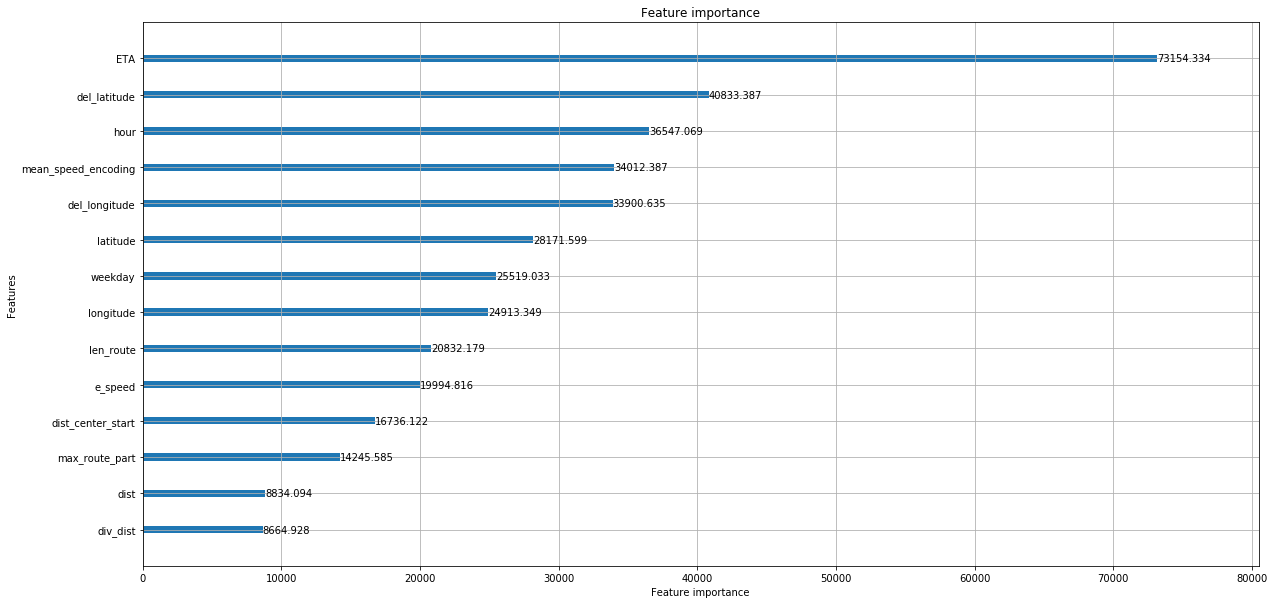

In [156]:
# Посмотрим Features Importamce
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
lgb.plot_importance(bst, importance_type='gain')

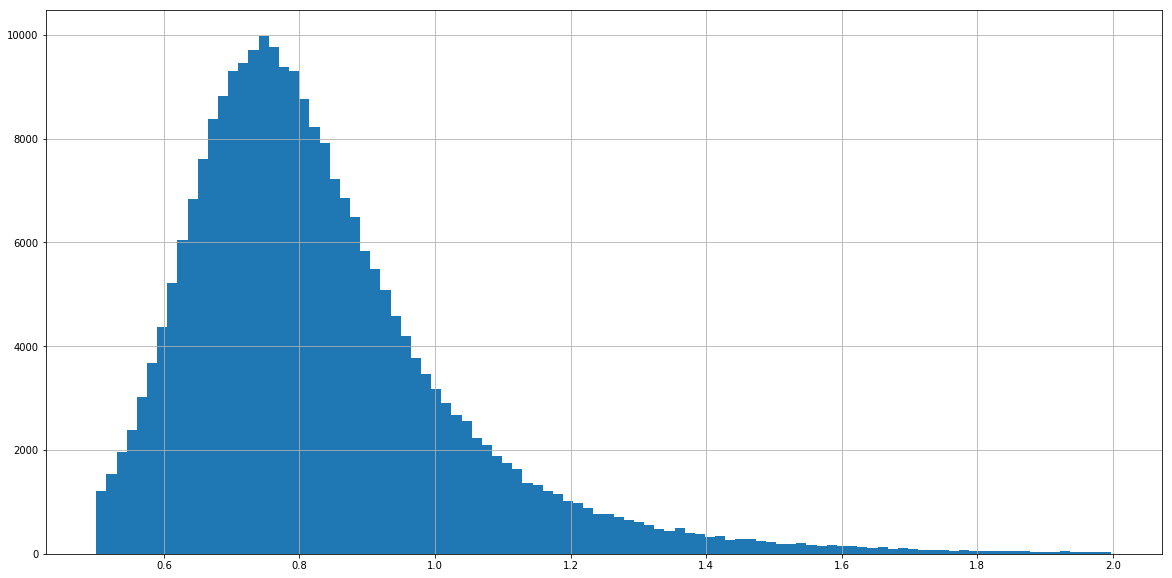

In [157]:
# Распредление таргета
(data[target] / data['ETA']).hist(bins = 100)

In [22]:
# Делаем файл сабмита
test_pred = np.clip(bst.predict(np.array(data[train_cols]))[ltr:], 0.5, 2) * data['ETA'][ltr:]
test['Prediction'] = test_pred.values - (data['ETA'][ltr:].values * best_k)
test[['Id', 'Prediction']].to_csv('final_submition.csv', index = None)

In [23]:
# Сохраняем модель
import pickle
with open('bst.pickle', 'wb') as f:
    pickle.dump([bst, best_k], f)